# Assignment 3
In this assignment you will implement a non-trivial problem that processes Big Data. To facilitate its processing in a regular computer, the actual amount of data will not be big, but the techniques that you will implement would scale to larger volumes of data.

This assignment is wort 15% of the total assessment of the unit.

This assignment relates to the following Learning Outcomes:
* Apply Map-reduce techniques to a number of problems that involve Big Data.
* Apply Big Data techniques to data mining.


The following code unzips the data stored in tweets.zip. This is the same data you used in Assignment 2.

In [1]:
import zipfile
from pathlib import Path
if not Path('10000 tweets-NEW.json').exists():
    print("Unzipping tweets")
    with zipfile.ZipFile('cleaned-tweets.zip') as myzip:
        myzip.extractall()

The following code implements a [Python generator](https://wiki.python.org/moin/Generators) that simulates a stream of tweets. You will use this iterator in some of the following tasks. The function uses the `yield` statement instead of a `return` statement so that it does not need to read the entire file into memory. By doing this, the function can work with files of  unlimited size.

In [2]:
import json
def stream_tweets():
    with open('10000 tweets-NEW.json', encoding='iso8859-1') as jfile:
        for line in jfile:
            try:
                next_tweet = json.loads(line)
            except:
                next_tweet = "Tweet error"
            yield next_tweet

There will be a demonstration of the use of this code in the lectures and workshops. Below is an example of how it can be used in a loop:

In [3]:
counter = 0
for s in stream_tweets():
    if counter > 3:
        break
    counter += 1
    print(s)

{'id': 'tag:search.twitter.com,2005:715690137900941312', 'objectType': 'activity', 'actor': {'objectType': 'person', 'id': 'id:twitter.com:18064228', 'link': 'http://www.twitter.com/Intelledox', 'displayName': 'Intelledox', 'postedTime': '2008-12-11T23:47:55.000Z', 'image': 'https://pbs.twimg.com/profile_images/485981380585603072/inMuMtJ7_normal.png', 'summary': "Intelledox's mobile-ready digitalization software helps over 1 million people to do business faster, smarter & efficiently Digitalize your business process now!", 'links': [{'href': 'http://www.intelledox.com', 'rel': 'me'}], 'friendsCount': 486, 'followersCount': 549, 'listedCount': 24, 'statusesCount': 1188, 'twitterTimeZone': 'Canberra', 'verified': False, 'utcOffset': '39600', 'preferredUsername': 'Intelledox', 'languages': ['en'], 'location': {'objectType': 'place', 'displayName': 'Canberra, Australia'}, 'favoritesCount': 55}, 'verb': 'post', 'postedTime': '2016-04-01T00:00:00.000Z', 'generator': {'displayName': 'HubSpot'

## Task 1 (5 marks)
Fill the gaps in the class below that processes the stream and issues the following standing queries:

* (1 mark) The length of the shortest tweet and the length of the longest tweet so far.
* (2 marks) The twitter ID of the person who has posted most tweets in the last 1000 posts.
* (2 marks) The twitter ID of the most active twitter when we apply an exponentially decaying window with $c=10^{-3}$ and a threshold of 0.5.

In your implementation, make sure that the system scales well to unlimited streams, and answer the following question:

1. How much memory do you need to reserve to keep the information about each of the standing queries?

In [4]:
import numpy as np
#from collections import Counter
class StreamProcessor:
    c = 10**-3
    threshold = 0.5
    shortest = np.inf
    longest = 0
    last1000 = []
    last1000_counter = dict()
    mostactive = dict()
    def step(self, item):
        """Process one item from the stream and return the answers to the
        standing queries as a Python dictionary with the following keys:
          - shortest
          - longest
          - most_frequent
          - most_active
        """
        userid = item['actor']['id']
        post = item['body']
        
        # 1
        if len(post) < self.shortest:
            self.shortest = len(post)
        if len(post) > self.longest:
            self.longest = len(post)
            
        # 2
        if len(self.last1000) >= 1000:
            olduser = self.last1000.pop()
            #self.last1000_frequencies[olduser] -= 1
            self.last1000_counter[olduser] -= 1
            if userid != olduser and self.last1000_counter[olduser] == 0:
                del self.last1000_counter[olduser]
        self.last1000 = [userid] + self.last1000
        if userid in self.last1000_counter:
            self.last1000_counter[userid] += 1
        else:
            self.last1000_counter[userid] = 1
            
        most_frequent = sorted(self.last1000_counter.items(), key = lambda x: x[1])[-1][0]
        
        #3
        new_data = {}
        for s in self.mostactive:
            self.mostactive[s] *= (1-self.c)
            if s == userid:
                self.mostactive[s] += 1
            if self.mostactive[s] >= self.threshold:
                new_data[s] = self.mostactive[s]
        if userid not in self.mostactive:
            new_data[userid] = 1
        self.mostactive = new_data
        tmp_max = 0
        tmp_id = None
        for k in self.mostactive:
            if self.mostactive[k] > tmp_max:
                tmp_max = self.mostactive[k]
                tmp_id = k
            
        return {#'current': userid,
                'shortest': self.shortest,
                'longest': self.longest,
                'most_frequent': most_frequent,
                'most_active': tmp_id}

The following code will apply the stream processor to the first 5 elements of the stream.

In [5]:
counter = 0
stream = StreamProcessor()
for s in stream_tweets():
    if s == 'Tweet error':
        continue
    if counter >= 5:
        break
    counter += 1
    print(stream.step(s))

{'shortest': 140, 'longest': 140, 'most_frequent': 'id:twitter.com:18064228', 'most_active': 'id:twitter.com:18064228'}
{'shortest': 138, 'longest': 140, 'most_frequent': 'id:twitter.com:188921458', 'most_active': 'id:twitter.com:188921458'}
{'shortest': 127, 'longest': 140, 'most_frequent': 'id:twitter.com:97578801', 'most_active': 'id:twitter.com:97578801'}
{'shortest': 127, 'longest': 140, 'most_frequent': 'id:twitter.com:3266593548', 'most_active': 'id:twitter.com:3266593548'}
{'shortest': 127, 'longest': 140, 'most_frequent': 'id:twitter.com:225568917', 'most_active': 'id:twitter.com:225568917'}


## Task 2 (5 marks)
Apply the minhashing techniques we have covered in week 7 to determine the set of near-duplicates among the tweet posts. For this exercise use only the first 500 tweet posts (so that you do not need to wait too long). To complete this assignment you can reuse code from the lecture notebooks and from the workshop exercises. Use your judgement to determine the parameters and answer the following questions:

1. What value of $k$ did you use to represent the $k$-shingles and why?
2. Did you hash the $k$-shingles and why?
3. If you hashed the $k$-shingles, how many buckets did you use and why?
4. How many hashes did you use for minhashing, how many buckets, and why?
5. How many bands and rows did you use for locality-sensitive hashing and why?

*(The following code generates the minhash matrix basically by copying and pasting material from the lectures)*

In [6]:
def my_hash(item, target_range):
    return hash(item) % target_range

In [7]:
import nltk
def k_hash_shingle(text, k, hash_function, target_range):
    return set(hash_function(item, target_range) 
               for item in nltk.ngrams(text, k))

In [8]:
k = 9
target_range = 1000000
counter = 0
stream = StreamProcessor()
kshingles = []
tweets = []
for s in stream_tweets():
    if s == 'Tweet error':
        continue
    if counter >= 500:
        break
    counter += 1
    kshingles.append(k_hash_shingle(s['body'], k, my_hash, target_range))
    tweets.append(s['body'])
len(kshingles)

500

In [9]:
def permute_hash(item, hash_index, target_range):
    return (hash(item) * (hash_index+1) + 1) % target_range

In [10]:
import numpy as np
def minhash(kshingles,
            permute_hash_function, signature_rows,
            target_range,
            verbose=False):
    sig = np.ones((signature_rows, len(kshingles))) * np.inf
    for r in range(target_range):
        if r % 1000 == 0:
            print(r)
        for c, ks in enumerate(kshingles):
            if r not in ks:
                continue
            for i in range(signature_rows):
                sig[i, c] = min(sig[i,c], 
                                permute_hash_function(r, i, target_range))
        if verbose:
            print("After scanning row %i" % r)
            print("Signature matrix:")
            print(sig)
    return sig

In [11]:
sig = minhash(kshingles, permute_hash, 100, target_range)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [12]:
np.shape(sig)

(100, 500)

*(The following code implements locality sensitive hashing)*

Let's attempt to find near neighbours for Jaccard similarity $s=0.9$. We then look for values of $b$ and $r$ so that $(1/b)^{(1/r)} = 0.9$. Since we have 100 rows, then $r=100/b$. So, an approximate value of $b$ is: 5. This makes 5 bands with 20 rows each. This way the Jaccard similarity results in: $(1/5)^{1/20}=0.92$.

In [13]:
candidates = set()
for b in range(5):
    print("Processing band %i" % b)
    for c1 in range(np.shape(sig)[1]):
        hash1 = hash(tuple(sig[b*20:(b+1)*20, c1]))
        for c2 in range(c1+1, np.shape(sig)[1]):
            hash2 = hash(tuple(sig[b*20:(b+1)*20, c2]))
            if hash1 == hash2:
                print((c1,c2))
                candidates.add((c1,c2))
print(candidates)

Processing band 0
(69, 106)
(131, 133)
(131, 134)
(133, 134)
(139, 142)
(214, 215)
(214, 216)
(215, 216)
(235, 238)
(279, 292)
(337, 342)
(393, 394)
(404, 410)
Processing band 1
(69, 106)
(131, 133)
(131, 134)
(133, 134)
(139, 142)
(214, 215)
(214, 216)
(215, 216)
(235, 238)
(279, 292)
(337, 342)
(393, 394)
(404, 410)
Processing band 2
(69, 106)
(131, 133)
(131, 134)
(133, 134)
(139, 142)
(214, 215)
(214, 216)
(215, 216)
(235, 238)
(279, 292)
(337, 342)
(393, 394)
(404, 410)
Processing band 3
(69, 106)
(131, 133)
(131, 134)
(133, 134)
(139, 142)
(214, 215)
(214, 216)
(215, 216)
(235, 238)
(279, 292)
(337, 342)
(393, 394)
(404, 410)
Processing band 4
(69, 106)
(131, 133)
(131, 134)
(133, 134)
(139, 142)
(214, 215)
(214, 216)
(215, 216)
(235, 238)
(279, 292)
(337, 342)
(393, 394)
(404, 410)
{(279, 292), (404, 410), (69, 106), (214, 215), (214, 216), (133, 134), (393, 394), (337, 342), (139, 142), (131, 134), (235, 238), (215, 216), (131, 133)}


In [14]:
for c1, c2 in candidates:
    print()
    print(tweets[c1])
    print(tweets[c2])


RT @Tha5SOSFamily: Luke #5SOSFam #BestFanArmy #iHeartAwards
RT @Tha5SOSFamily: Luke #5SOSFam #BestFanArmy #iHeartAwards

RT @HITS1031: Support the AACA Clothing KickstarterÂ Campaign https://t.co/lBlJSXFNp0 https://t.co/sE2oas0pZJ
RT @HITS1031: Support the AACA Clothing KickstarterÂ Campaign https://t.co/lBlJSXFNp0 https://t.co/sE2oas0pZJ

RT @FamousWomen: Love is always a demonstration - not just a set of words or a feeling.
RT @FamousWomen: Love is always a demonstration - not just a set of words or a feeling.

RT @Dubagee: FBI Unlocks San Bernardino Shooters Phone... #breakingnews #funny #SNL https://t.co/JOzNrC6wmH via @YouTube
RT @Dubagee: FBI Unlocks San Bernardino Shooters Phone... #breakingnews #funny #SNL https://t.co/JOzNrC6wmH via @YouTube

RT @Dubagee: FBI Unlocks San Bernardino Shooters Phone... #breakingnews #funny #SNL https://t.co/JOzNrC6wmH via @YouTube
RT @Dubagee: FBI Unlocks San Bernardino Shooters Phone... #breakingnews #funny #SNL https://t.co/JOzNrC6wmH via @You

## Task 3 (5 marks)
Implement a MapReduce version of PageRank **using combiners** as described in the lectures of week 9. The MapReduce version should incorporate teleporting with $\beta=0.85$. 

For this assignment we will use Pythons built-in functions `map` and `reduce`. For example, the following code is a Python version that uses MapReduce to compute the sum of squares of the numbers in a list:

In [15]:
from functools import reduce
def my_square(x):
    return x**2

def my_sum(x,y):
    return x+y

my_list = [1, 2, 3, 4, 5]

def mapreduce(a_list):
    temp = map(my_square, a_list) # Note that map returns an iterator, not a list
    return reduce(my_sum, temp)

mapreduce(my_list)

55

In [16]:
1+2**2+3**2+4**2+5**2

55

The above Python code is not efficient and it does not take advantage of parallel computing units (you can search the Web for parallel versions) but it will serve for this assignment. 

Note that `map` returns a Python iterator and not a list and there are operations that cannot be performed on it. For example, you cannot select a slice or compute the length:

In [17]:
temp = map(my_square, my_list)
print(len(temp))

TypeError: object of type 'map' has no len()

In [18]:
temp = map(my_square, my_list)
print(temp[0:2])

TypeError: 'map' object is not subscriptable

For this assignment, use an artificially generated network such as the one used in the workshop of week 9. The code is:

In [19]:
def generate_network(n, sparsity):
    "Return a transition matrix with n nodes"
    # Fill the matrix
    result = np.zeros((n,n))
    for i in range(int(n*n - n*n*sparsity)):
        x = np.random.randint(n)
        y = np.random.randint(n)
        result[x,y] = 1
        
    # Normalise the results
    for c in range(n):
        degree = np.sum(result[:, c])
        if degree > 0:
            result[:, c] /= degree
    return result

In [20]:
generate_network(5,0.7)

array([[ 1. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0.5,  0. ,  1. ,  0. ],
       [ 0. ,  0.5,  0.5,  0. ,  1. ],
       [ 0. ,  0. ,  0.5,  0. ,  0. ]])

* In your demonstration, generate a network with 20 nodes and compute the PageRank of each node. 
* Your solution must include a graph that shows how the PageRank changes at each iteration.
* Do not attempt to remove dead ends (to simplify this exercise).
* What size of blocks did you use for your solution?

In [21]:
M = generate_network(20, 0.7)

The following code does not use MapReduce (it's based on the lecture notebook). Use it for your reference.

PR after 7 iterations:
[[ 0.02013622]
 [ 0.02483551]
 [ 0.04794672]
 [ 0.0862338 ]
 [ 0.05301735]
 [ 0.04229551]
 [ 0.03083306]
 [ 0.06599589]
 [ 0.07750014]
 [ 0.07408755]
 [ 0.03673395]
 [ 0.04477559]
 [ 0.0626477 ]
 [ 0.04320856]
 [ 0.06037354]
 [ 0.03730683]
 [ 0.04065174]
 [ 0.02294645]
 [ 0.04899973]
 [ 0.07947416]]


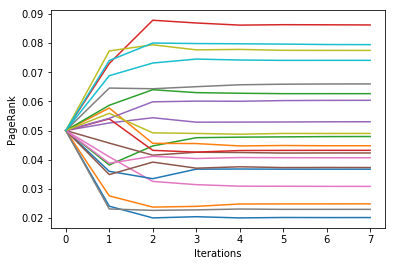

In [22]:
% matplotlib inline
from matplotlib import pyplot as plt

epsylon = 0.0001
beta = 0.85
PR = np.ones((20, 1)) / 20
iterations = 0
oldPR = np.zeros((20,1))
allPR = [PR]
while max(np.abs(oldPR-PR)) > epsylon:
    oldPR = PR
    PR = beta*(np.dot(M, PR)) + (1-beta)/20*np.ones((20,1))
    allPR.append(PR)
    iterations += 1
print("PR after %i iterations:" % iterations)
print(PR)
for p in range(20):
    data = [onePR[p,0] for onePR in allPR]
    plt.plot(data)
plt.xlabel("Iterations")
plt.ylabel("PageRank")

Write the solution with MapReduce below.

PR after 9 iterations:
[[ 0.02009783]
 [ 0.02477633]
 [ 0.04778699]
 [ 0.08592901]
 [ 0.05287637]
 [ 0.04218398]
 [ 0.03076785]
 [ 0.06580996]
 [ 0.07727873]
 [ 0.07386643]
 [ 0.03663401]
 [ 0.04467283]
 [ 0.06249748]
 [ 0.04310934]
 [ 0.06023095]
 [ 0.03722781]
 [ 0.04056085]
 [ 0.02290449]
 [ 0.04887911]
 [ 0.07921552]]


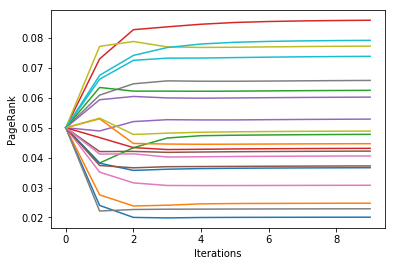

In [23]:
import copy

def my_map(item):
    m, pr = item
    return np.dot(m, pr)

def my_reduce(x1, x2):
    return x1 + x2

epsylon = 0.0001
beta = 0.85
PR = np.ones((20, 1)) / 20
iterations = 0
oldPR = np.zeros((20,1))
allPR = [copy.deepcopy(PR)]

M_blocks = [M[r*4:(r+1)*4, c*4:(c+1)*4] for r in range(5) for c in range(5)]

while max(np.abs(oldPR-PR)) > epsylon:
    oldPR = copy.deepcopy(PR)
    
    # MapReduce is implemented here
    PR_blocks = [PR[c*4:(c+1)*4,:] for b in range(5) for c in range(5)]
    assert len(M_blocks) == len(PR_blocks)
    temp = map(my_map, zip(M_blocks, PR_blocks))
    for b in range(5):
        data = [next(temp) for i in range(5)]
        result = reduce(my_reduce, data)
        PR[b*4:(b+1)*4] = beta*result + (1-beta)/20*np.ones((4,1))
    allPR.append(copy.deepcopy(PR))
    iterations += 1
print("PR after %i iterations:" % iterations)
print(PR)
for p in range(20):
    data = [onePR[p,0] for onePR in allPR]
    plt.plot(data)
plt.xlabel("Iterations")
plt.ylabel("PageRank")

Below is an alternative solution that uses MapReduce in a form that is closer to the approach you were taught in the first half of COMP336. The following code implements the MapReduce framework:

In [24]:
import itertools
def map_reduce(i,mapper,reducer):
  intermediate = []
  for (key,value) in i.items():
    intermediate.extend(mapper(key,value))
  groups = {}
  for key, group in itertools.groupby(sorted(intermediate), 
                                      lambda x: x[0]):
    groups[key] = list([y for x, y in group])
  return [reducer(intermediate_key,groups[intermediate_key])
          for intermediate_key in groups]

For example, the following code would use MapReduce to count word frequencies in a list of tweets.

In [25]:
def mapper(key, value):
    return [(w, 1) for w in value.split()]
def reducer(key, values):
    return key, sum(values)

In [26]:
import zipfile
from pathlib import Path
if not Path('10000 tweets-NEW.json').exists():
    print("Unzipping tweets")
    with zipfile.ZipFile('cleaned-tweets.zip') as myzip:
        myzip.extractall()

In [27]:
import json
def get_tweets(ntweets):
    with open('10000 tweets-NEW.json', encoding='iso8859-1') as jfile:
        result = dict()
        i = 0
        for line in jfile:
            if i >= ntweets:
                break
            try:
                next_tweet = json.loads(line)
                tweet_id = next_tweet['id']
                tweet_body = next_tweet['body']
            except:
                continue
            result[tweet_id] = tweet_body
            i += 1
    return result

In [28]:
tweets_500 = get_tweets(500)

In [29]:
map_reduce(tweets_500, mapper, reducer)

[('!', 1),
 ('"April', 1),
 ('"Basic', 1),
 ('"Blade', 1),
 ('"Clean', 1),
 ('"Demons"', 1),
 ('"Eat', 1),
 ('"I', 2),
 ('"I\'ll', 1),
 ('"It\'s', 1),
 ('"Mistakes', 1),
 ('"Need', 2),
 ('"Our', 1),
 ('"Spike', 1),
 ('"Team', 1),
 ('"Trump', 1),
 ('"We', 2),
 ('"We\'ll', 1),
 ('"due', 1),
 ('"first', 1),
 ('"i', 2),
 ('"jokes".', 1),
 ('"leaders"', 1),
 ('"lives', 1),
 ('"minor', 1),
 ('"small', 1),
 ('"strike"', 1),
 ('"the', 1),
 ('"why', 2),
 ('"you', 1),
 ('##Greece:', 1),
 ('#25', 1),
 ('#2DayFMRnB', 1),
 ('#5SOSFam', 12),
 ('#AC360', 1),
 ('#ACTLearn', 1),
 ('#AFC', 1),
 ('#ARwx', 1),
 ('#AirportLine', 1),
 ('#April', 1),
 ('#AprilFoolsâ\x80¦', 1),
 ('#AskMo', 1),
 ('#AskTheHorse', 1),
 ('#Asset', 1),
 ('#AusOpen', 1),
 ('#Auspol', 2),
 ('#Australia', 1),
 ('#BLACKOUT', 1),
 ('#BanSnares', 1),
 ('#BernieInTheBroâ\x80¦', 1),
 ('#BestFanArmy', 12),
 ('#BestFanArâ\x80¦', 1),
 ('#BigBangTheory', 1),
 ('#BlackLivesMatter', 1),
 ('#Burma', 1),
 ('#CEO', 1),
 ('#CTUStrike', 1),
 ('#CX',

The solution to compute PageRank is below.

PR after 7 iterations:
[[ 0.02013622]
 [ 0.02483551]
 [ 0.04794672]
 [ 0.0862338 ]
 [ 0.05301735]
 [ 0.04229551]
 [ 0.03083306]
 [ 0.06599589]
 [ 0.07750014]
 [ 0.07408755]
 [ 0.03673395]
 [ 0.04477559]
 [ 0.0626477 ]
 [ 0.04320856]
 [ 0.06037354]
 [ 0.03730683]
 [ 0.04065174]
 [ 0.02294645]
 [ 0.04899973]
 [ 0.07947416]]


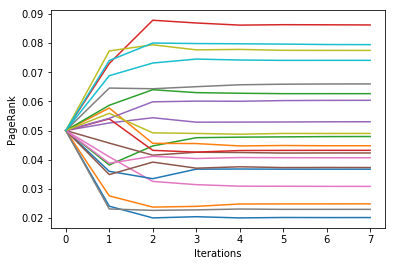

In [30]:
% matplotlib inline
from matplotlib import pyplot as plt
import copy

def my_map(key, value):
    i, j = key
    m, pr = value
    assert m.shape == (4, 4)
    assert pr.shape == (4, 1)
    return [(i, np.dot(m, pr).tolist())]

def my_reduce(key, values):
    result = np.zeros((4,1))
    for v in values:
        result += v
    assert result.shape == (4,1)
    return key, result

epsylon = 0.0001
beta = 0.85
PR = np.ones((20, 1)) / 20
iterations = 0
oldPR = np.zeros((20,1))
allPR = [copy.deepcopy(PR)]


while max(np.abs(oldPR-PR)) > epsylon:
    oldPR = copy.deepcopy(PR)
    
    # MapReduce is implemented here
    mr_data = dict()
    for r in range(5):
        for c in range(5):
            mr_data[(r,c)] = (M[r*4:(r+1)*4, c*4:(c+1)*4], PR[c*4:(c+1)*4,:])
    result = map_reduce(mr_data, my_map, my_reduce)
    for j, value in result:
        PR[j*4:(j+1)*4] = beta*value + (1-beta)/20*np.ones((4,1))
    allPR.append(copy.deepcopy(PR))
    iterations += 1
print("PR after %i iterations:" % iterations)
print(PR)
for p in range(20):
    data = [onePR[p,0] for onePR in allPR]
    plt.plot(data)
plt.xlabel("Iterations")
plt.ylabel("PageRank")